# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import glob

In [2]:
datagen = ImageDataGenerator(rescale=1./255)

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
train_datagen_flow = datagen.flow_from_dataframe(
    dataframe = labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)

Found 7591 validated image filenames.


In [5]:
labels.shape

(7591, 2)

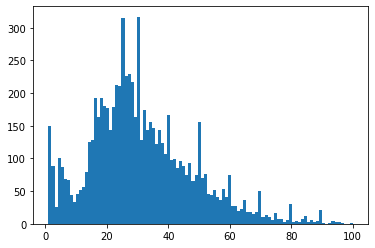

In [6]:
plt.hist(labels['real_age'], bins=100);

In [ ]:
for _ in range(0, 15):
    image, label = train_datagen_flow.next()
    plt.imshow(image[0])
    label_name=label[0] 
    plt.title(label_name)
    plt.show()

### Вывод

* Датасет состоит из таргета - возраст клиента и признаков - названий файлов, где хранятся фотографии;
* Всего в датасете 7,5 тыс. фотографий, чего достаточно для обучения сети;
* Есть всплески около 2-х, 25-и лет, из-за чего сети будет труднее обучаться;
* Также мы имеем регулярные всплески каждые 10 лет после 30
* При выведении фото можно увидеть, что есть фото с поворотами и черно-белые фото, где лица показаны крупным планом;
* Обычно аугментации необходимо делать, если данных мало и модель переобучится, тем самыв "размножив" обучающую выборку. Поэтому аугментации проводить в данном случае не будем.

## Обучение модели

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):

    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):

    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

### Вывод консоли

Train for 178 steps, validate for 60 steps
<br>
Epoch 1/10
<br>
2022-09-07 10:49:31.558539: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
<br>
2022-09-07 10:49:31.942836: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
<br>
178/178 - 49s - loss: 228.8499 - mae: 10.9322 - val_loss: 905.6030 - val_mae: 25.2627
<br>
Epoch 2/10
<br>
178/178 - 40s - loss: 59.0818 - mae: 5.8114 - val_loss: 929.8181 - val_mae: 25.6890
<br>
Epoch 3/10
<br>
178/178 - 40s - loss: 29.3735 - mae: 4.1878 - val_loss: 401.3479 - val_mae: 15.2029
<br>
Epoch 4/10
<br>
178/178 - 40s - loss: 19.1810 - mae: 3.3921 - val_loss: 268.3670 - val_mae: 12.9682
<br>
Epoch 5/10
<br>
178/178 - 40s - loss: 14.4206 - mae: 2.9401 - val_loss: 90.4970 - val_mae: 7.4548
<br>
Epoch 6/10
<br>
178/178 - 40s - loss: 12.1982 - mae: 2.6952 - val_loss: 87.8671 - val_mae: 7.0787
<br>
Epoch 7/10
<br>
178/178 - 40s - loss: 10.7801 - mae: 2.5246 - val_loss: 66.4314 - val_mae: 6.1287
<br>
Epoch 8/10
<br>
178/178 - 39s - loss: 9.6019 - mae: 2.3530 - val_loss: 66.3687 - val_mae: 6.0465
<br>
Epoch 9/10
<br>
178/178 - 39s - loss: 8.5579 - mae: 2.2105 - val_loss: 73.9931 - val_mae: 6.6979
<br>
Epoch 10/10
<br>
178/178 - 39s - loss: 8.1288 - mae: 2.1507 - val_loss: 65.5350 - val_mae: 6.1019
<br>
WARNING:tensorflow:sample_weight modes were coerced from
<br>
  ...
  <br>
    to  
  ['...']
  <br>
60/60 - 10s - loss: 65.5350 - mae: 6.1019
Test MAE: 6.1019

## Анализ обученной модели

При обучении была использована сеть ResNet50. За 10 эпох модель уменьшила MAE тестовой выборки до 6.1019. При загрузке данных размер батча указан 32.

Впринципе модель показала неплохие результаты, учитывая выбросы около 5 лет, 28 и 32 лет.

* При обучении модели использована сеть ResNet50 с урезанной верхушкой и весами с Imagenet
* Параметры обучения
    * Размер батча 32
    * Оптимизатор Adam
    * Без заморозки весов
    * Количество эпох 10
* Метрика тестовой выборки отличается от метрики тренировочной почти в 3 раза, поэтому можно сказать, что модель переобучена.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы